# 🌍 Global Trends Walkthrough — Meditation Trend Pulse

This notebook demonstrates how the **Global Trends page** of the Meditation Trend Pulse Streamlit app was built.  

The live dashboard is fully automated and interactive, but this notebook serves as a **static walkthrough** that:  
- Loads the same cleaned datasets powering the Global Trends page  
- Reconstructs the key **tables and charts** shown in the app  
- Documents the **design choices and logic** behind each visual  

### Why this notebook matters
- Provides a **transparent record** of how the Global Trends page was designed  
- Helps hiring managers understand the **end-to-end pipeline** from data → visualization  
- Creates static, reproducible visuals that mirror the Streamlit experience  

### Contents
1. 📈 Interest Over Time  
2. 🔄 Percent Change (5-Year Comparison)  
3. ⭐ Top Peaks in Search Interest  

In [1]:
# ──────────────────────────────────────────────
# 📦 Setup — Global Trends Walkthrough Notebook
# ──────────────────────────────────────────────

import os                   # File and directory operations
import pandas as pd         # Data manipulation and analysis
import matplotlib.pyplot as plt  # plotting library for static charts
from pytrends.request import TrendReq  # Google Trends API wrapper

# Configure pandas display for cleaner outputs
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 10)
pd.set_option("display.float_format", "{:,.2f}".format)

## 📡 Initialize Pytrends Client

This cell sets up the Google Trends client and defines the core keyword set used for the **Global Trends page**.

### What this does
- Creates a `pytrends` client for querying Google Trends  
- Fixes the timezone (UTC−6) so weekly bins align consistently  
- Declares the five keywords tracked across the dashboard  

### Parameters
- `hl="en-US"` → results in English  
- `tz=360` → timezone offset in minutes (UTC−6)  
- `timeout=(15, 45)` → connection/read timeouts for stability  

### Keywords Tracked
- meditation  
- mindfulness  
- breathwork  
- guided meditation  
- yoga nidra  

In [2]:
# ──────────────────────────────────────────────
# 📡 Pytrends Client Setup
# ──────────────────────────────────────────────

# Initialize Google Trends client with clear defaults
pytrends = TrendReq(
    hl="en-US",        # Interface language
    tz=360,            # Timezone offset in minutes (UTC-6 → weekly bins align well)
    timeout=(15, 45),  # (connect timeout, read timeout) in seconds
)

# Core set of tracked keywords — consistent across project
KEYWORDS = [
    "meditation",
    "mindfulness",
    "breathwork",
    "guided meditation",
    "yoga nidra",
]

### 📥 Pulling and Reshaping Google Trends Data

To begin, we use **Pytrends** to fetch 5 years of weekly search interest data for all five keywords in a single request.  
By default, Google Trends provides a **wide format** (one column per keyword).  

For analysis and visualization, we reshape this into a **long format**:  
- Each row now represents a `(date, keyword, search_interest)` triple  
- This structure is easier to plot, aggregate, and compare across keywords  
- It also matches the tidy data principles that power our Streamlit app  

This section outputs both versions (wide and long) to clearly show the transformation.

In [3]:
# ──────────────────────────────────────────────
# 📊 Pull 5-Year Weekly Interest for All Keywords
# ──────────────────────────────────────────────

# Build one payload for all keywords (5-year window, worldwide)
pytrends.build_payload(
    kw_list=KEYWORDS,
    timeframe="today 5-y",
    geo=""
)

# Fetch wide-format dataframe (one column per keyword + date)
df_wide = pytrends.interest_over_time()

# Drop helper column if present and reset index so 'date' is a column
df_wide = (
    df_wide.drop(columns=["isPartial"], errors="ignore")
           .reset_index()
)

# Convert from wide (date + one column per keyword) to → long (date, keyword, search_interest)
df_long = (
    df_wide.melt(
        id_vars=["date"],        # keep 'date' as identifier
        value_vars=KEYWORDS,     # collapse keyword columns
        var_name="keyword",      # new column: keyword name
        value_name="search_interest",  # new column: interest value
    )
    .dropna(subset=["date"])                # ensure valid dates only
    .sort_values(["date", "keyword"])       # predictable sort
    .reset_index(drop=True)                 # clean row index
)

# Quick look at the first 10 rows
df_long.head(10)

/Users/saayedalam/jupyterlab-env/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,date,keyword,search_interest
0,2020-09-13,breathwork,1
1,2020-09-13,guided meditation,6
2,2020-09-13,meditation,93
3,2020-09-13,mindfulness,25
4,2020-09-13,yoga nidra,3
5,2020-09-20,breathwork,1
6,2020-09-20,guided meditation,5
7,2020-09-20,meditation,92
8,2020-09-20,mindfulness,26
9,2020-09-20,yoga nidra,3


### 📈 Visual: Interest Over Time (5 Years)

The chart below shows weekly Google Trends interest (scaled 0–100) for each keyword over the past 5 years.  
It provides a static snapshot of long-term patterns in search behavior.

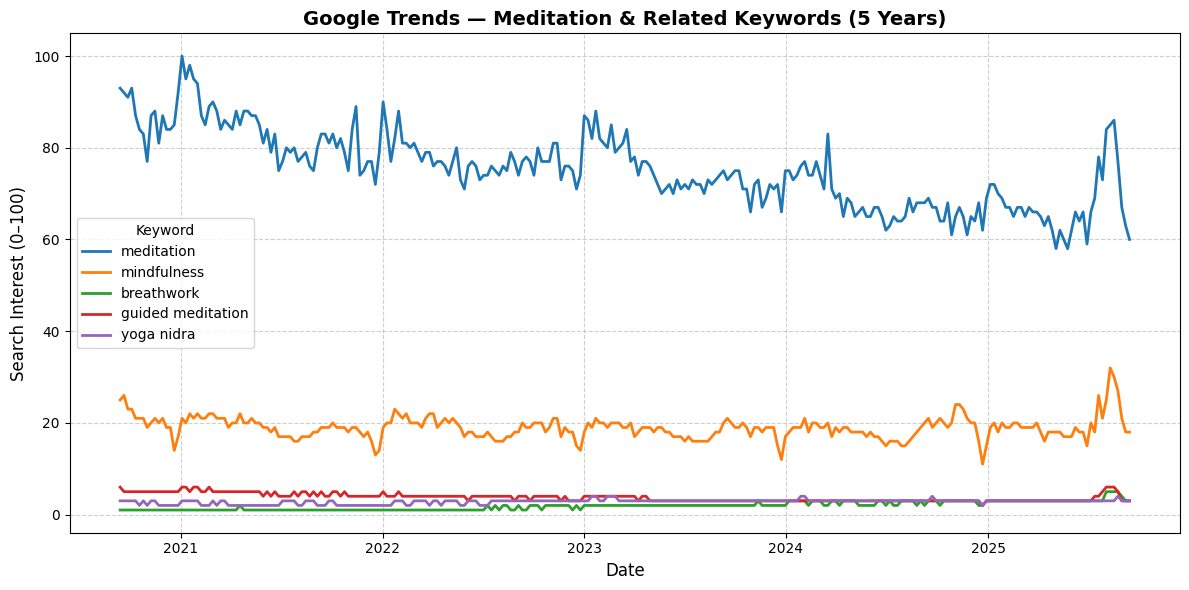

In [4]:
# ──────────────────────────────────────────────
# 📊 Visualize Global Search Interest (5 Years)
# ──────────────────────────────────────────────
plt.figure(figsize=(12, 6))

# Plot each keyword's trend separately
for keyword in KEYWORDS:
    subset = df_long[df_long["keyword"] == keyword]
    plt.plot(
        subset["date"], 
        subset["search_interest"], 
        label=keyword, 
        linewidth=2   # thicker lines for clarity
    )

# Titles and labels
plt.title(
    "Google Trends — Meditation & Related Keywords (5 Years)",
    fontsize=14,
    weight="bold"
)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Interest (0–100)", fontsize=12)

# Legend and grid
plt.legend(title="Keyword", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)

# Layout optimization
plt.tight_layout()
plt.show()

### 🔄 Compute 5‑Year Percent Change per Keyword

We pivot to wide (date × keyword), fill edges with forward/backward fill, then compute percent change over the 5‑year window:

$$\%\Delta = \frac{\text{last} - \text{first}}{\text{first}} \times 100$$

This mirrors the **5‑Year Change (%)** table in the app.

In [5]:
# ──────────────────────────────────────────────
# 🔄 Compute 5‑Year Percent Change per Keyword
# ──────────────────────────────────────────────

# Pivot long → wide: index=date, columns=keyword, values=search_interest
wide = (
    df_long
    .pivot(index="date", columns="keyword", values="search_interest")
    .sort_index()
)

# Fill edges so first/last are defined per column (handles early/late NaNs)
wide_filled = wide.ffill().bfill()

# First/last values across the 5‑year window (per keyword)
first = wide_filled.iloc[0]
last  = wide_filled.iloc[-1]

# Percent change per keyword
pct_change = ((last - first) / first) * 100.0

# Tidy to two columns: keyword, percent_change
df_pct_change = (
    pct_change.rename("percent_change")
              .reset_index()
              .rename(columns={"index": "keyword"})
              .loc[:, ["keyword", "percent_change"]]
)

# Round and sort for readability (matches Streamlit table behavior)
df_pct_change["percent_change"] = df_pct_change["percent_change"].round(2)
df_pct_change = df_pct_change.sort_values("percent_change", ascending=False).reset_index(drop=True)

# Preview data
df_pct_change

,keyword,percent_change
0,breathwork,200.00
1,yoga nidra,0.00
2,mindfulness,-28.00
3,meditation,-35.48
4,guided meditation,-50.00


### 📊 Visual: 5-Year Percent Change by Keyword

The chart below compares the relative growth (or decline) in search interest  
for each keyword over the past 5 years.  

- Bars are **sorted** so the fastest-growing keywords appear at the top  
- Values are expressed as **percent change** between the first and last week in the dataset  
- This static view mirrors the percent-change table in the Streamlit app

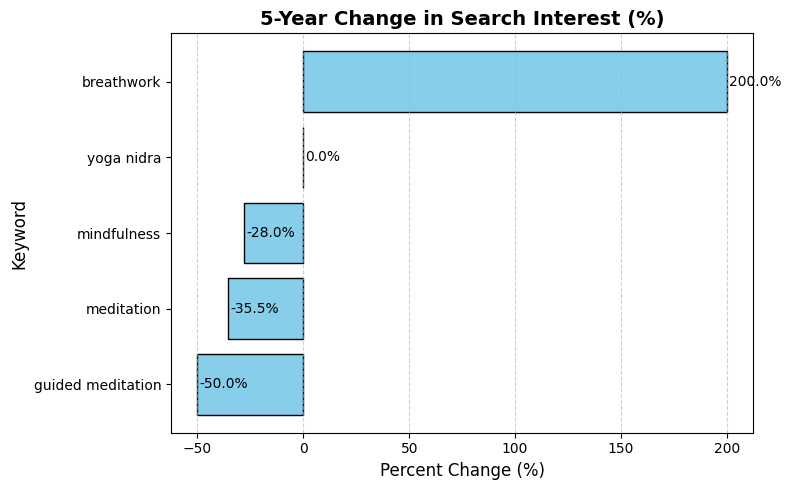

In [6]:
# ──────────────────────────────────────────────
# 📊 Visualize 5-Year Percent Change by Keyword
# ──────────────────────────────────────────────

plt.figure(figsize=(8, 5))

# Horizontal bar chart (df_pct_change is already sorted descending)
plt.barh(
    df_pct_change["keyword"],
    df_pct_change["percent_change"],
    color="skyblue",
    edgecolor="black"
)

plt.title("5-Year Change in Search Interest (%)", fontsize=14, weight="bold")
plt.xlabel("Percent Change (%)", fontsize=12)
plt.ylabel("Keyword", fontsize=12)

# Add value labels next to bars
for i, v in enumerate(df_pct_change["percent_change"]):
    plt.text(v + 1, i, f"{v:.1f}%", va="center", fontsize=10)

# Reverse y-axis so largest % is at top
plt.gca().invert_yaxis()

# Layout optimization
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

### ⭐ Top 3 Peak Weeks by Keyword  

The table below highlights the **three highest points of search interest** for each keyword over the past 5 years.  
These peaks capture moments of unusually high attention and provide context for major surges in meditation-related searches.  

In [7]:
# ──────────────────────────────────────────────
# ⭐ Extract Top 3 Peak Weeks per Keyword
# ──────────────────────────────────────────────

df_top_peaks = (
    df_long
    .sort_values(["keyword", "search_interest"], ascending=[True, False]) # Sort rows by descending search_interest
    .groupby("keyword", as_index=False, sort=False)
    .head(3) # Select the top 3 rows (highest peaks)
    .sort_values(["keyword", "search_interest"], ascending=[True, False]) # Re-sort by keyword for clarity
    .reset_index(drop=True)
)

# Preview the result (10 rows)
df_top_peaks.head(10)

,date,keyword,search_interest
0,2025-08-03,breathwork,5
1,2025-08-10,breathwork,5
2,2025-08-17,breathwork,5
3,2020-09-13,guided meditation,6
4,2021-01-03,guided meditation,6
5,2021-01-10,guided meditation,6
6,2021-01-03,meditation,100
7,2021-01-17,meditation,98
8,2021-01-10,meditation,95
9,2025-08-10,mindfulness,32


### ⭐ Visual: Top 3 Peaks in Search Interest

This chart highlights the **top three spikes in weekly Google Trends interest** for each keyword across the past 5 years.  

- Each line shows the full trend history for a keyword  
- Large markers indicate the **three highest points** in that trend  
- The single **highest peak** per keyword is annotated with its date for clarity  

Together, these peaks reveal moments of exceptional global attention — key surges that stand out from baseline search behavior.  

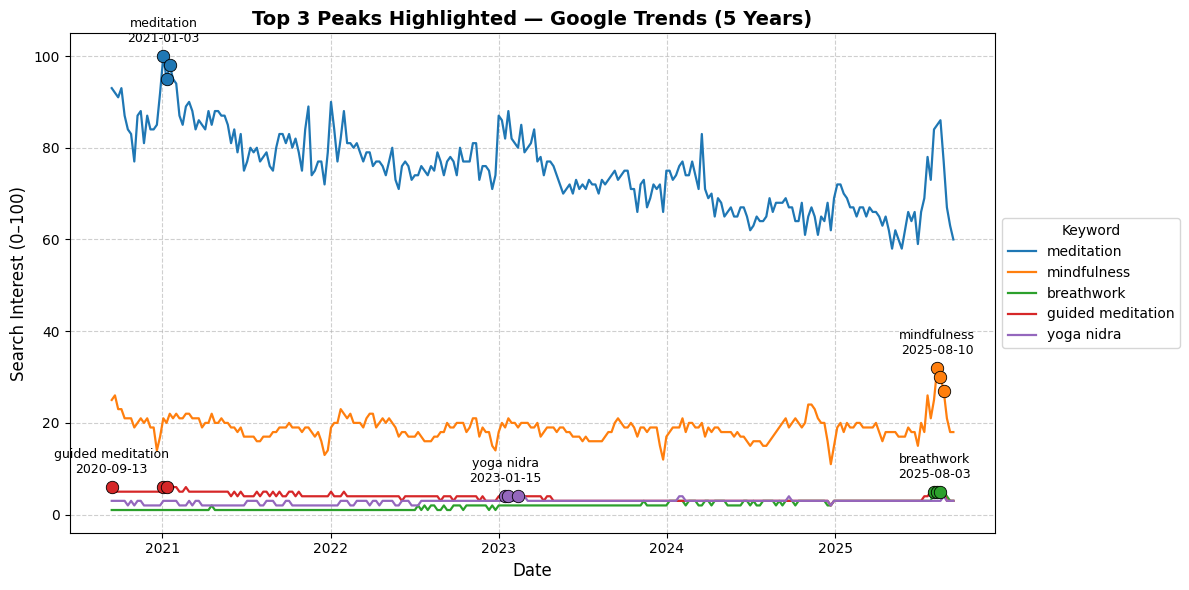

In [8]:
# ──────────────────────────────────────────────
# ⭐ Overlay Top 3 Peaks on 5‑Year Lines
# ──────────────────────────────────────────────
plt.figure(figsize=(12, 6))

# Plot the full time series for each keyword
for kw in KEYWORDS:
    series = df_long[df_long["keyword"] == kw]
    plt.plot(series["date"], series["search_interest"], label=kw, linewidth=1.6)

# Overlay top-3 peaks per keyword as larger markers
for kw in KEYWORDS:
    peaks = df_top_peaks[df_top_peaks["keyword"] == kw].copy()
    if peaks.empty:
        continue
    # Use scatter for emphasis
    plt.scatter(
        peaks["date"], peaks["search_interest"],
        s=80, marker="o", edgecolors="black", linewidths=0.6, zorder=5
    )
    # Label only the highest peak per keyword to avoid clutter
    top1 = peaks.sort_values("search_interest", ascending=False).head(1)
    for _, row in top1.iterrows():
        plt.annotate(
            f"{kw}\n{row['date'].date()}",
            xy=(row["date"], row["search_interest"]),
            xytext=(0, 10),
            textcoords="offset points",
            fontsize=9,
            ha="center"
        )

plt.title("Top 3 Peaks Highlighted — Google Trends (5 Years)", fontsize=14, weight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Search Interest (0–100)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

# Move legend to the right outside the plot
plt.legend(title="Keyword", fontsize=10, loc="center left", bbox_to_anchor=(1, 0.5), frameon=True)

plt.tight_layout()
plt.show()

## ✅ Conclusion — Global Trends Walkthrough

In this notebook, we reconstructed the key elements of the **Global Trends page** from the Meditation Trend Pulse dashboard using static, reproducible visuals.  

### What we demonstrated
- 📈 **Interest Over Time** — long-term weekly search patterns for meditation-related keywords  
- 🔄 **5-Year Percent Change** — growth and decline trends across keywords  
- ⭐ **Top Peaks** — exceptional spikes in search interest that mark global attention shifts  

### Why this matters
This walkthrough makes the **design logic transparent** and shows how raw Google Trends data was shaped into insights for stakeholders.  
While the live Streamlit app is automated and interactive, this notebook ensures there’s a **clear, static record** of the pipeline and visuals behind it. 